In [11]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm

In [2]:
A = np.random.rand(5, 2)

In [3]:
from scipy.optimize import linprog

# Solve: Find x such that A x <= 1 - ε
epsilon = 1e-3
n_ineq = A.shape[0]

res = linprog(c=[0, 0], A_ub=A, b_ub=np.ones(n_ineq) - epsilon)

if res.success:
    interior_point = res.x

In [4]:
res.success

True

In [5]:
interior_point

array([0., 0.])

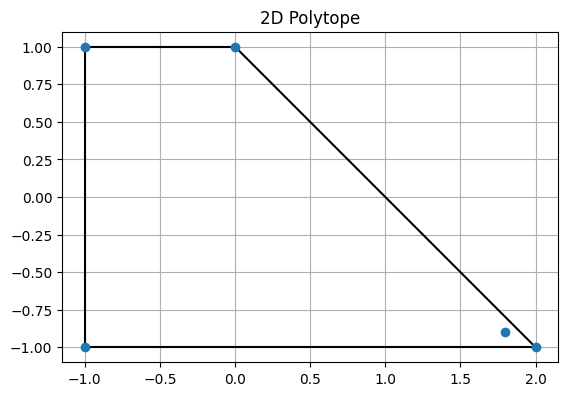

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import HalfspaceIntersection
from scipy.spatial import ConvexHull

# Example A: n x 2 matrix
A = np.array([
    [1, 1],
    [-1, 0],
    [0, 1],
    [0, -1]
])

b = np.ones(len(A))  # a_i x <= 1

halfspaces = np.hstack((A, -b[:, None]))

# Feasible interior point (must strictly satisfy all constraints)
interior_point = np.array([0.0, 0.0])  # Make sure this is inside the polytope

hs = HalfspaceIntersection(halfspaces, interior_point)

# Plot
fig, ax = plt.subplots()
for simplex in ConvexHull(hs.intersections).simplices:
    points = hs.intersections[simplex]
    ax.plot(points[:, 0], points[:, 1], 'k-')
ax.plot(*zip(*hs.intersections), 'o')  # Vertices
ax.set_aspect('equal')
plt.grid(True)
plt.title("2D Polytope")
plt.scatter(1.8, -0.9)
plt.show()

In [7]:
log_density = lambda x: -0.5 * torch.linalg.norm(x + 0.75, axis=-1) ** 2 \
                    * torch.linalg.norm(x - 0.25, axis=-1) ** 2

In [16]:
# particle = torch.tensor(np.array([1.8, -0.9]), requires_grad=True, dtype=torch.float64)
# particle = torch.tensor(np.array([0, 0]), requires_grad=True, dtype=torch.float64)
A_torch = torch.tensor(A, dtype=torch.float64)
dt = 0.01

num_iters = 10_000
history = torch.zeros(num_iters, 2)
for i in range(num_iters):
    val = log_density(particle)
    val.backward()
    
    with torch.no_grad():
        A_temp = A_torch / (1 - A_torch @ particle)[:, None] ** 2
        H = A_temp.T @ A_temp
        
        # C = torch.linalg.cholesky(H)
        eig_vals, eig_vecs = torch.linalg.eigh(H)
        # eig_vals = torch.clip(eig_vals, 0.01, 100)
        C = eig_vecs @ torch.diag(1 / torch.sqrt(eig_vals)) @ eig_vecs.T
        H = eig_vecs @ torch.diag(1 / eig_vals) @ eig_vecs.T
        # C = torch.eye(2, dtype=torch.float64)
        # H = C
        
        # temp_particle = particle + dt * H @ particle.grad + np.sqrt(2 * dt) * C @ torch.randn_like(particle)
        # temp_particle = particle + np.sqrt(2 * dt) * C @ torch.randn_like(particle)
        temp_particle = particle + dt * particle.grad + np.sqrt(2 * dt) * C @ torch.randn_like(particle)
        if (A_torch @ temp_particle <= 1).all():
            particle[:] = temp_particle
        
        history[i] = particle.detach().clone()
    
    particle.grad.zero_()
    
history = history.detach().clone().numpy()

In [17]:
eig_vals

tensor([338.8688, 663.3494], dtype=torch.float64)

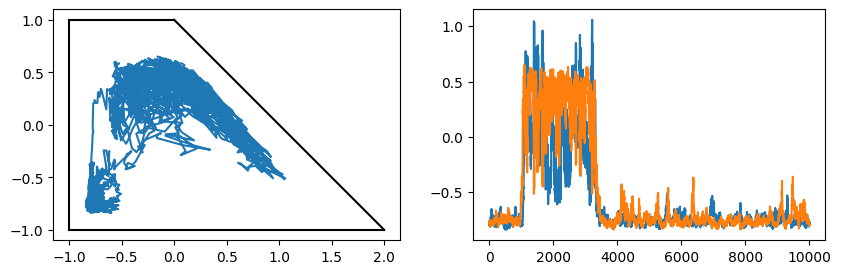

In [18]:
halfspaces = np.hstack((A, -b[:, None]))

interior_point = np.array([0.0, 0.0])

hs = HalfspaceIntersection(halfspaces, interior_point)

fig, ax = plt.subplots(1, 2, figsize=(10, 3))
for simplex in ConvexHull(hs.intersections).simplices:
    points = hs.intersections[simplex]
    ax[0].plot(points[:, 0], points[:, 1], 'k-')
    

# temp_particle = torch.tensor([0.9, -0.9], dtype=torch.float64)
temp_particle = particle.detach().clone()
A_temp = A_torch / (1 - A_torch @ temp_particle)[:, None] ** 2
H = A_temp.T @ A_temp
H /= torch.diag(H).norm()
x = particle.detach().numpy()
H_sqrt = sqrtm(H.detach().numpy())

# Parametrize the unit circle
theta = np.linspace(0, 2 * np.pi, 200)
circle = 0.000001 * np.vstack((np.cos(theta), np.sin(theta)))  # shape (2, N)

# Apply transformation to get ellipsoid
ellipsoid = np.linalg.inv(H_sqrt) @ circle + x[:, None]  # shape (2, N)

# ax[0].plot(ellipsoid[0], ellipsoid[1])
ax[0].set_aspect('equal')
    
ax[0].plot(history[:, 0], history[:, 1])
ax[1].plot(history[:, 0])
ax[1].plot(history[:, 1])

In [19]:
# plt.plot(np.linalg.norm(history - 0.25, axis=1));

# Diff

In [30]:
log_density = lambda x: -0.5 * torch.linalg.norm(x + 0.75, axis=-1) ** 2 \
                    * torch.linalg.norm(x - 0.25, axis=-1) ** 2

In [59]:
# particle = torch.tensor(np.array([1.8, -0.9]), requires_grad=True, dtype=torch.float64)
particle = torch.tensor(np.array([0, 0]), requires_grad=True, dtype=torch.float64)
A_torch = torch.tensor(A, dtype=torch.float64)
dt = 0.01

num_iters = 10_000
history = torch.zeros(num_iters, 2)
for i in range(num_iters):
    val = log_density(particle)
    val = 1 * torch.log(1 - A_torch @ particle).sum()
    val = torch.log(1 - A_torch @ particle).sum()
    val.backward()
    
    with torch.no_grad():
        # temp_particle = particle + dt * H @ particle.grad + np.sqrt(2 * dt) * C @ torch.randn_like(particle)
        # temp_particle = particle + np.sqrt(2 * dt) * C @ torch.randn_like(particle)
        temp_particle = particle + dt * particle.grad + np.sqrt(2 * dt) * torch.randn_like(particle)
        if (A_torch @ temp_particle <= 1).all():
            particle[:] = temp_particle
        
        history[i] = particle.detach().clone()
    
    particle.grad.zero_()
    
history = history.detach().clone().numpy()

In [60]:
eig_vals

tensor([338.8688, 663.3494], dtype=torch.float64)

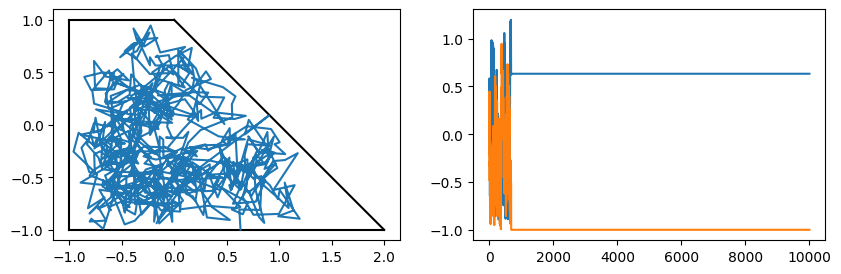

In [61]:
halfspaces = np.hstack((A, -b[:, None]))

interior_point = np.array([0.0, 0.0])

hs = HalfspaceIntersection(halfspaces, interior_point)

fig, ax = plt.subplots(1, 2, figsize=(10, 3))
for simplex in ConvexHull(hs.intersections).simplices:
    points = hs.intersections[simplex]
    ax[0].plot(points[:, 0], points[:, 1], 'k-')
    

# temp_particle = torch.tensor([0.9, -0.9], dtype=torch.float64)
temp_particle = particle.detach().clone()
A_temp = A_torch / (1 - A_torch @ temp_particle)[:, None] ** 2
H = A_temp.T @ A_temp
H /= torch.diag(H).norm()
x = particle.detach().numpy()
H_sqrt = sqrtm(H.detach().numpy())

# Parametrize the unit circle
theta = np.linspace(0, 2 * np.pi, 200)
circle = 0.000001 * np.vstack((np.cos(theta), np.sin(theta)))  # shape (2, N)

# Apply transformation to get ellipsoid
ellipsoid = np.linalg.inv(H_sqrt) @ circle + x[:, None]  # shape (2, N)

# ax[0].plot(ellipsoid[0], ellipsoid[1])
ax[0].set_aspect('equal')
    
ax[0].plot(history[:, 0], history[:, 1])
ax[1].plot(history[:, 0])
ax[1].plot(history[:, 1])